# Remote Sensing Exercise - Part B

In this  exercise you will analyze some data from our SUHI database.

In particular, what we will do:

1. Open the Database and use SQL to retrieve data from it.
2. Calculate the daily SUHI intensity (SUHII) for Mexico city.
3. Caclulate the monthly and annual means for SUHII and rural LST.
4. Visualize the SUHII seasonal hysteresis of Mexico city.
5. Visualize the SUHII seasonal hystereis in each densely-populated climate of Earth.

## Database Tables

The SUHI database includes six tables that store the aggregated satellite data (2000-2020) and other ancillary information. These six tables are the following:

| Table        | Description                                               | 
| ------------ | ----------------------------------------------------------| 
| `cities`     | The cities and their atrributes.                          | 
| `countries`  | The world's countries and their chracteristics.           |
| `data_day`   | The daytime data.                                         |
| `data_night` | The nighttime data.                                       |
| `city_size`  | The area  [km<sup>2</sup>] of each city polygon per year. |
| `land_covers`| The land cover legend.                                    |

To view the database in your pc you can use this software: https://dbeaver.io/.

## Setting up what we need...

In [ ]:
# First load your Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# After mounting, check folders in left side-bar
# If this code does not work, you can use the "Mount Drive" button in the left side-bar

Mounted at /content/drive


In [ ]:
# Set relevant directories
import os

# Your own baseline directory - if mounted under MyDrive, do not change.
BASE_DIR = os.path.join('/content/drive/MyDrive/BUCSS22')
print('BASE_DIR: ',BASE_DIR)

# Create a link to notebooks directory
YOUR_NAME = "Panagiotis_Lecturer" # Name of your own folder
NOTEBOOKS_DIR = os.path.join(BASE_DIR, YOUR_NAME, 'notebooks')
print('NOTEBOOKS_DIR: ',NOTEBOOKS_DIR)

# Other relevant folders
LST_DIR         = os.path.join(BASE_DIR, 'DATA_SHARE', 'LST')
print('DATA_DIR: ',LST_DIR)

BASE_DIR:  /content/drive/MyDrive/BUCSS22
NOTEBOOKS_DIR:  /content/drive/MyDrive/BUCSS22/Panagiotis_Lecturer/notebooks
DATA_DIR:  /content/drive/MyDrive/BUCSS22/DATA_SHARE/LST


# Basics

To retrieve data from an SQLite database we will use the [`pandas.read_sql()`](https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html) method, which will return a `pandas.Dataframe` with the queried data. This method takes as input a string describing a SQL `SELECT` statement. The `SELECT` statement is used to select data from a database and in its simplest form it looks like this:
```sql
SELECT column1, column2, ...
FROM table_name;
```
where, `column1`, and `column2` are the field names of the table you want to select data from and `table_name` is the name of the table.

## B.1 Simplest case

**Goal**: Retrieve all the rows from the columns `UID` (used instead of name), `country`, `latitude`, and `longitude` in the table `cities`.

In [ ]:
# Step 1: import the `pandas` and `sqlite3` modules
import pandas as pd
import sqlite3

# Step 2: open a connection to the database.
filename = os.path.join(LST_DIR, "SUHI_DB-MOD11A1.061-v1.0.1.db")
connection = sqlite3.connect(filename)

# Step 3: create a sql query
sql_query = "SELECT UID, country, latitude, longitude FROM cities"

# Step 4: retieve data from the database
cities = pd.read_sql(
    sql = sql_query,
    con = connection,  
)

# Step 5: close the database connection
connection.close()

# and you are done! :)
cities.head()

,UID,country,latitude,longitude
0,MEX-199510,Mexico,18.925,-99.21
1,MEX-19959,Mexico,19.050,-98.21
2,MEX-19958,Mexico,19.285,-99.62
3,MEX-201610,Mexico,19.535,-98.90
4,MEX-19957,Mexico,19.440,-99.11


To check the number of rows, use the `len()` method:

In [ ]:
print(f"Number of rows: {len(cities)}")

Number of rows: 16


### B.2 Select Rows based on Condition

**Goal**: Same as above, but now keep only the rows where the city elevation is at least 200 m and the climate is classified as oceanic.

In [ ]:
import pandas as pd
import sqlite3

filename = os.path.join(LST_DIR, "SUHI_DB-MOD11A1.061-v1.0.1.db")
connection = sqlite3.connect(filename)

# select only the cities where the climate is oceanic (Cfb)
# and the city elevation is equal or greater than 200 m.
sql_query ="""
    SELECT UID, country, latitude, longitude
    FROM cities
    WHERE climate = "Cwb"
    AND elevation >= 200
    """

cities = pd.read_sql(
    sql = sql_query,
    con = connection,  
)

connection.close()

print(cities.head())
print(f"Number of rows: {len(cities)}")

          UID country  latitude  longitude
0   MEX-19959  Mexico    19.050     -98.21
1   MEX-19958  Mexico    19.285     -99.62
2  MEX-201610  Mexico    19.535     -98.90
3   MEX-19957  Mexico    19.440     -99.11
4   MEX-19956  Mexico    19.700    -101.20
Number of rows: 5


Now, let's do the same without hardcoding the threshold values:

In [ ]:
import pandas as pd
import sqlite3

filename = os.path.join(LST_DIR, "SUHI_DB-MOD11A1.061-v1.0.1.db")
connection = sqlite3.connect(filename)

sql_query =\
"""
    SELECT UID, country, latitude, longitude, elevation
    FROM cities
    WHERE climate=:climate_zone
    AND elevation>=:min_elevation
"""

# Create a dictionary to store the threshold values.
# The keys should have the same names as in the sql_query!
query_args = {
    "climate_zone": "Cwb",
    "min_elevation": 200,
}

cities = pd.read_sql(
    sql = sql_query,
    con = connection,
    params = query_args,
)

connection.close()

display(cities.head())
print(f"Number of rows: {len(cities)}")

,UID,country,latitude,longitude,elevation
0,MEX-19959,Mexico,19.050,-98.21,2145.0
1,MEX-19958,Mexico,19.285,-99.62,2618.5
2,MEX-201610,Mexico,19.535,-98.90,2241.0
3,MEX-19957,Mexico,19.440,-99.11,2243.0
4,MEX-19956,Mexico,19.700,-101.20,1900.0


Number of rows: 5


## Let's get started...

In [ ]:
# First let's import all the modules we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")
sns.set_context("notebook")

We will start by creating a function to get data from the database.

The function should take as input arguments the city ID and the land cover, where:

| Land Cover | Value |
| ---------- | ----- |
| Urban      | 0 |
| Rural      | 1 |

In [ ]:
def get_data(city: str, land_cover: int) -> pd.DataFrame:
    """Get data from the SUHI database."""

    filename = os.path.join(LST_DIR, "SUHI_DB-MOD11A1.061-v1.0.1.db")
    connection = sqlite3.connect(filename)

    sql_query =\
    """
        SELECT date, lst_mean, lst_min, lst_max
        FROM data_day
        WHERE UID=:city_UID
        AND pxl_perc >= 20
        AND vza_median >= -55
        AND vza_median <= 55
        AND vza_range <= 10
        AND lcc=:lcc_ID

    """

    query_args = {
        "city_UID": city,
        "lcc_ID": land_cover,
    }

    data = pd.read_sql(
        sql = sql_query,
        con = connection,
        params = query_args,
    )

    connection.close()
    
    data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
    data.set_index("date", inplace=True)
    
    return data

Let's use the function to get the LST data for the City of Mexico (`UID = "MEX-19957"`).

In [ ]:
df_urban = get_data(city="MEX-19957", land_cover=0)

df_urban.head()

,lst_mean,lst_min,lst_max
date,,,
2010-01-07,294.65,287.38,300.76
2010-01-10,289.86,284.84,293.18
2010-01-15,290.16,281.40,297.06
2010-01-16,293.09,286.20,297.20
2010-01-28,301.45,292.42,308.74


The number of rows is equal to:

In [ ]:
len(df_urban)

1314

> **Task**
> 
> Try to change the default values for `vza_median` and `pxl_perc` values in `sql_query` and see how it affects the dataframe size.

Before we move on, let's plot the LST means for Mexico City.

Text(0, 0.5, 'LST [K]')

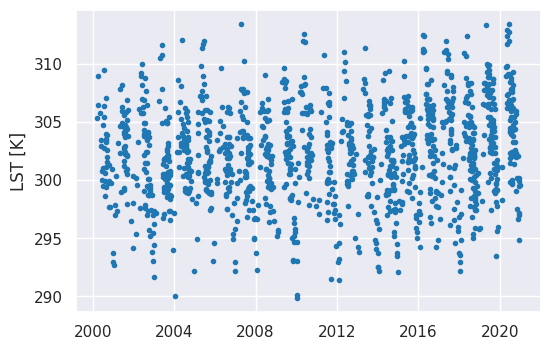

In [ ]:
# plot the time series
plt.plot(df_urban["lst_mean"], ".", label="Mean")
plt.ylabel("LST [K]")

## Task 2: Calculate the SUHI Intensity

To calculate the SUHI intensity we also need the rural LST.

In [ ]:
df_rural = get_data(city="MEX-19957", land_cover=1)
display(df_rural.head())
print("Number of rows: ", len(df_rural))

,lst_mean,lst_min,lst_max
date,,,
2010-01-14,294.35,288.02,300.02
2010-01-15,293.02,284.94,296.10
2010-01-16,294.31,288.74,298.72
2010-01-17,298.66,287.08,303.48
2010-01-19,301.32,294.58,305.08


Number of rows:  3591


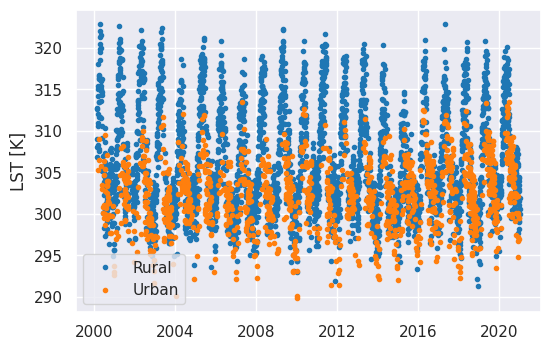

In [ ]:
# Let's visualize the two datasets.
plt.plot(df_rural.lst_mean, ".", label="Rural")
plt.plot(df_urban.lst_mean, ".", label="Urban")
plt.ylabel("LST [K]")
plt.legend()

To calculate the SUHI intensity we first need to join the two dataframes:

In [ ]:
# Use the merge() method to join the two dataframes.
df_mexcity = pd.merge(
    df_urban,
    df_rural,
    on="date",
    how="inner",
    suffixes=("_urban", "_rural"),
    validate="one_to_one",
)

display(df_mexcity.head())
print("Number of rows: ", len(df_mexcity))

,lst_mean_urban,lst_min_urban,lst_max_urban,lst_mean_rural,lst_min_rural,lst_max_rural
date,,,,,,
2010-01-15,290.16,281.40,297.06,293.02,284.94,296.10
2010-01-16,293.09,286.20,297.20,294.31,288.74,298.72
2010-01-28,301.45,292.42,308.74,300.50,292.40,306.62
2010-02-08,298.13,285.42,306.42,297.05,291.90,302.64
2010-02-13,300.29,291.80,309.14,302.00,292.28,307.16


Number of rows:  861


Calculate the urban and rural LST differences per day and store it into a new column:

In [ ]:
df_mexcity["suhii"] = df_mexcity["lst_mean_urban"] - df_mexcity["lst_mean_rural"]

display(df_mexcity.head())
print("Number of rows: ", len(df_mexcity))

,lst_mean_urban,lst_min_urban,lst_max_urban,lst_mean_rural,lst_min_rural,lst_max_rural,suhii
date,,,,,,,
2010-01-15,290.16,281.40,297.06,293.02,284.94,296.10,-2.86
2010-01-16,293.09,286.20,297.20,294.31,288.74,298.72,-1.22
2010-01-28,301.45,292.42,308.74,300.50,292.40,306.62,0.95
2010-02-08,298.13,285.42,306.42,297.05,291.90,302.64,1.08
2010-02-13,300.29,291.80,309.14,302.00,292.28,307.16,-1.71


Number of rows:  861


In [ ]:
# summarize our results
df_mexcity.describe()

,lst_mean_urban,lst_min_urban,lst_max_urban,lst_mean_rural,lst_min_rural,lst_max_rural,suhii
count,861.000000,861.000000,861.000000,861.000000,861.000000,861.000000,861.000000
mean,303.010139,293.392613,309.818304,303.637003,294.453194,310.843298,-0.626864
std,4.268740,4.184462,4.591904,5.402065,4.608564,6.205456,3.475543
min,290.160000,280.760000,297.060000,293.020000,284.260000,296.100000,-12.210000
25%,300.160000,290.500000,306.760000,299.600000,291.320000,306.080000,-3.170000
50%,303.050000,293.500000,309.920000,302.340000,293.560000,309.800000,-0.270000
75%,306.110000,296.300000,312.900000,306.410000,297.140000,315.320000,2.150000
max,313.480000,305.880000,322.620000,318.730000,309.320000,325.140000,6.980000


Text(0.5, 1.0, "The temporal variation of Mexico City's SUHI intensity")

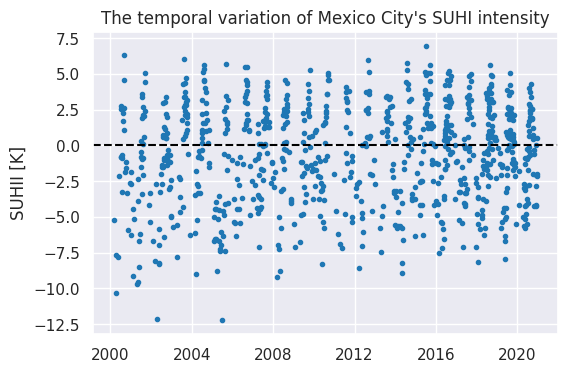

In [ ]:
# Let's also plot how SUHII varies temporally
plt.plot(df_mexcity.suhii, ".")
plt.axhline(y=0, color="black", ls="dashed")
plt.ylabel("SUHII [K]")
plt.title("The temporal variation of Mexico City's SUHI intensity")

## Task 3: Calculate the Annual and Monthly Means

In [ ]:
# We will start with the annual means
years = df_mexcity.index.year.rename("year")

annual_means = df_mexcity.groupby([years]).agg(
    suhii_mean=("suhii", "mean"),
    suhii_std=("suhii", "std"),                    
    rural_mean=("lst_mean_rural", "mean"),
    rural_std=("lst_mean_rural", "std"),  
    rural_count=("lst_mean_rural", "count"),
)

# sort by suhii_mean
annual_means.sort_values(by=["suhii_mean"], inplace=True)

# Print the table
annual_means.head(20)

,suhii_mean,suhii_std,rural_mean,rural_std,rural_count
year,,,,,
2005,-3.161081,4.139375,306.744324,6.381644,37
2002,-2.057000,3.584020,303.612250,5.791272,40
2001,-2.029706,4.158888,304.153824,4.758981,34
2014,-1.274250,3.877347,302.279750,5.662114,40
2000,-1.209231,3.963909,304.121154,5.630040,26
2011,-0.922917,3.740962,303.321667,4.987715,24
2020,-0.902542,2.821542,305.989831,5.238156,59
2008,-0.769730,3.734163,302.898378,4.697022,37
2012,-0.765333,3.711731,303.539667,5.911106,30


In [ ]:
# and continue with the monhtly means

months = df_mexcity.index.month.rename("month")

monthly_means = df_mexcity.groupby([months]).agg(
    suhii_mean=("suhii", "mean"),
    suhii_std=("suhii", "std"),                    
    rural_mean=("lst_mean_rural", "mean"),
    rural_std=("lst_mean_rural", "std"),  
    rural_count=("lst_mean_rural", "count"),
)

# sort by suhii_mean
monthly_means.sort_values(by=["suhii_mean"], inplace=True)

# Print the table
monthly_means.head(20)

,suhii_mean,suhii_std,rural_mean,rural_std,rural_count
month,,,,,
3,-4.498250,2.330093,308.980750,3.959996,40
4,-4.240192,2.805521,311.277308,4.360684,52
2,-4.179310,2.424659,303.478621,3.391788,29
5,-3.996341,2.705684,311.639512,4.070758,82
1,-3.280000,1.915011,298.876429,2.981886,28
12,-2.669783,1.998368,299.242826,2.563023,46
11,-1.780976,1.977043,300.011220,2.612487,41
6,-1.378182,3.503292,307.255195,5.228484,77
10,0.366447,1.885760,300.256053,2.383725,76


### Task 4: Visualize the SUHII Hysteresis

Let's try to visualize the time lag between rural LST and SUHI intensity for Mexico City.

Text(0, 0.5, 'SUHII [K]')

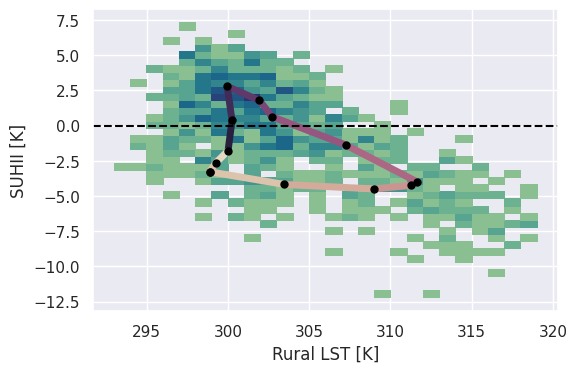

In [ ]:
# sort them according to month
monthly_means.sort_values(by=["month"], inplace=True)

# close the loop
means = monthly_means.append(monthly_means.iloc[0]) 

# Create a figure
fig, ax = plt.subplots()

sns.histplot(
    data=df_mexcity,
    x="lst_mean_rural",
    y="suhii",
    binwidth=[1, 0.5],
    cmap="crest",
    ax=ax
)

# This code block is for plotting each line segment with a differnt color.
pts = np.vstack([means["rural_mean"].values, means["suhii_mean"].values]).T 
pts_offset = np.roll(pts, 1, axis=0)
segments = np.array([np.vstack([pts[i,:], pts_offset[i,:]]) for i in range(13)])
dydx = np.linspace(0, 1, 11)
norm = plt.Normalize(dydx.min(), dydx.max())
cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
lc = LineCollection(segments, cmap=cmap, norm=norm, zorder=2)
lc.set_array(dydx)
lc.set_linewidth(5)
line = ax.add_collection(lc)

# Plot the monthly values
ax.scatter(
    means["rural_mean"],
    means["suhii_mean"],
    color="black",
    s=25,
    marker="o",
    zorder=3,
)

ax.axhline(y=0, color="black", ls="dashed")

ax.set_xlabel("Rural LST [K]")
ax.set_ylabel("SUHII [K]")

## Task 5

For this final task we will the monthly means I pre-calculates from our DB for almost 1500 cities around the globe.

Our goal is to visualize the SUHII Seasonal hysteresis for all the densely-populated climate zones.

In [ ]:
# Let's start by making a function to retrieve these data:

def get_monthy_means(climate: str):

    filename = os.path.join(LST_DIR, "SUHII_monthly_means.db")
    connection = sqlite3.connect(filename)

    query = """
    SELECT data_day.UID, months_relative_to_SE, suhii_mean, rural_mean
    FROM data_day 
    LEFT JOIN cities
    ON data_day.UID=cities.UID
    WHERE cities.climate=:climate_zone
    """

    query_args = {
        "climate_zone": climate,
    }

    data = pd.read_sql(
        sql = query,
        con = connection,
        params = query_args,
    )
    
    connection.close()

    return data

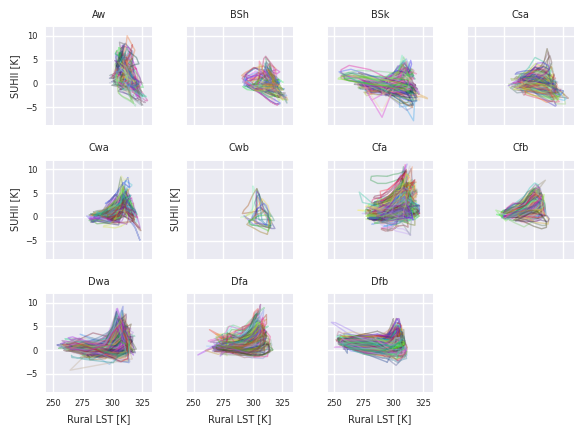

In [ ]:
# Let's visialize the data

ZONES = [
    "Aw",
    "BSh",
    "BSk",
    "Csa",
    "Cwa",
    "Cwb",
    "Cfa",
    "Cfb",
    "Dwa",
    "Dfa",
    "Dfb",
]

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(6.0, 4.5), sharex=True, sharey=True)

axs = axs.flatten()
axs[-1].remove()

for i, (zone, ax) in enumerate(zip(ZONES, axs)):

    loops_indiv_cities = get_monthy_means(zone)

    for UID in loops_indiv_cities["UID"].unique():

        city_mask = loops_indiv_cities["UID"] == UID
        city_loop = loops_indiv_cities.loc[city_mask]
        city_loop = city_loop.append(city_loop.iloc[0])  # close the loop

        ax.plot(
            city_loop["rural_mean"],
            city_loop["suhii_mean"],
            lw=1,
            color=np.random.rand(3,), # color each loop with a random color
            alpha = 0.35,
            zorder=1,
        )

    ax.tick_params(labelsize=6, which="both", width=0.5, length=2)
    ax.set_title(f"{zone}", fontsize=7)

    if i in [8, 9, 10]:
        ax.set_xlabel("Rural LST [K]", fontsize=7)

    if i in [0, 4, 5]:
        ax.set_ylabel("SUHII [K]", fontsize=7)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.7)
        
fig.tight_layout()
plt.show()

**Well done!**

The results that you see here have been published in: https://doi.org/10.3390/rs14102318
